In [45]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque

In [46]:
# hyperparameters
ALPHA = 5e-4
BATCH_SIZE = 32
DECAY_FACTOR = .99
EPISODE_LENGTH = 1000
EPSILON = 1
GAMMA = .99
MAXLEN = 100000
MIN_EPSILON = 0.01
REPLACE_COUNT = 100

In [47]:
class MLP(nn.Module):
    def __init__(self, state_size, n_action):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.value = nn.Linear(16, 1) # returns state value
        self.advantage = nn.Linear(16, n_action) # returns advantage of each action value pair

        self.loss = nn.MSELoss()
        self.optim = Adam(self.parameters(), lr=ALPHA)

    def forward(self, x):
        x = F.relu(self.fc1(torch.FloatTensor(x)))
        x = F.relu(self.fc2(x))
        value = self.value(x)
        advantage = self.advantage(x)
        q_value = value + (advantage - advantage.mean())
        return q_value

In [48]:
class DuelingDQN():
    def __init__(self):
        self.epsilon = EPSILON
        self.env = gym.make('CartPole-v1')
        self.n_action = self.env.action_space.n
        self.state_size = self.env.observation_space.shape[0]
        self.memory = deque(maxlen=MAXLEN)
        self.network = MLP(self.state_size, self.n_action)
        self.target = MLP(self.state_size, self.n_action)

    def remember(self, transition):
        self.memory.append(transition)

    def update_target(self, episode): # update the target network with model parameters
        if episode > 0 and episode % REPLACE_COUNT == 0:
            self.target.load_state_dict(self.network.state_dict())

    def get_action(self, state):
        if np.random.random() > self.epsilon:
            q_value = self.network(state)
            action = torch.argmax(q_value).item()
        else:
            action = np.random.choice(self.n_action)
        return action

    def learn(self, episode):
        if len(self.memory) < BATCH_SIZE:
            return

        self.update_target(episode)
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, _, reward, next_state, done in batch:
            network_qval = self.network(state)
            target_qval = reward + (1 - done) * GAMMA * self.target(next_state).detach()

            self.network.optim.zero_grad()
            loss = self.network.loss(target_qval, network_qval)
            loss.backward()
            self.network.optim.step()

    def decrement_epsilon(self):
        self.epsilon *= DECAY_FACTOR
        self.epsilon = max(self.epsilon, MIN_EPSILON)

    def act(self):
        total_return = []
        mean_return = []
        solved = False
        for episode in range(EPISODE_LENGTH):
            episodic_return = 0
            state = self.env.reset()
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episodic_return += reward
                self.remember([state, action, reward, next_state, done])
                self.learn(episode)
                self.decrement_epsilon()
                state = next_state

            total_return.append(episodic_return)
            mean_return.append(np.mean(total_return[-100:]))
            if mean_return[-1] >= 195.0 and not solved:
                print(f'Solved CartPole in {episode} episodes :)')
                solved = True
                break
            elif episode + 1 == EPISODE_LENGTH:
                print('You failed.')

        return total_return, mean_return

    def plot(self, returns, mean_return):
        plt.plot(returns, label='Episodic Return')
        plt.plot(mean_return, label='Mean Return')
        plt.title('Dueling DQN Training Curve')
        plt.legend()
        plt.xlabel('Episodes')
        plt.ylabel('Total Return')
        plt.show()

You failed.


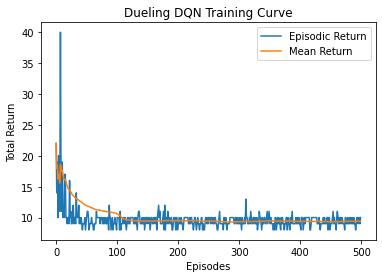

In [44]:
if __name__ == '__main__':
    agent = DuelingDQN()
    total_return, mean_return = agent.act()
    agent.plot(total_return, mean_return)